In [1]:
import math
import time

import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sns
import torch

sns.set_theme()

if torch.cuda.is_available():
    device = "cuda"
    print(f"Available device: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()
else:
    raise Exception("CUDA not available")

Available device: NVIDIA RTX A1000 6GB Laptop GPU


In [2]:
# Define the acquisition protocol

bvals = torch.tensor([1, 2.2]).to(device)

In [3]:
# Define the neural network

model = torch.nn.Sequential(
    torch.nn.Linear(2, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 2),
).to(device)

print(
    f"{sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters"
)

461826 trainable parameters


In [4]:
# Define the signal model


def E(bvals, lambda_cyls, v_cyls):
    return v_cyls.unsqueeze(1) * (
        math.sqrt(math.pi)
        * torch.erf(torch.sqrt(bvals.unsqueeze(0) * lambda_cyls.unsqueeze(1)))
        / (2 * torch.sqrt(bvals.unsqueeze(0) * lambda_cyls.unsqueeze(1)))
    ) + (1 - v_cyls).unsqueeze(1) * (
        math.sqrt(math.pi)
        * torch.erf(
            torch.sqrt(
                bvals.unsqueeze(0)
                * (
                    lambda_cyls.unsqueeze(1)
                    - ((1 - v_cyls).unsqueeze(1) * lambda_cyls.unsqueeze(1))
                )
            )
        )
        / (
            2
            * torch.sqrt(
                bvals.unsqueeze(0)
                * (
                    lambda_cyls.unsqueeze(1)
                    - ((1 - v_cyls).unsqueeze(1) * lambda_cyls.unsqueeze(1))
                )
            )
        )
    ) * torch.exp(
        -bvals.unsqueeze(0) * ((1 - v_cyls).unsqueeze(1) * lambda_cyls.unsqueeze(1))
    )

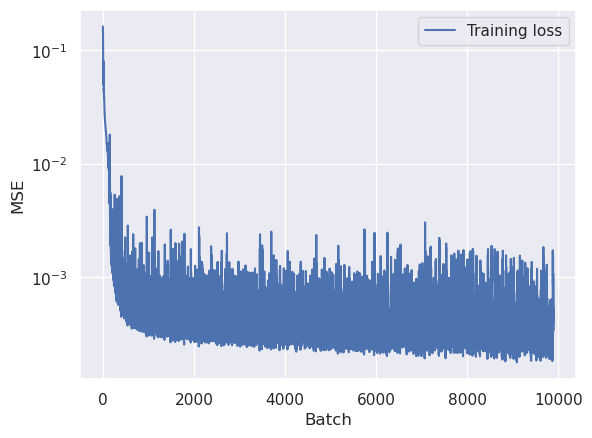

batch = 10000, loss = 0.0006410980713553727
Training took 244 min


In [5]:
# Train the network

batch_size = int(1e6)
n_batches = int(1e4)
n_iter = 10

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = torch.nn.MSELoss()

losses = []
start_time = time.time()
for batch in range(n_batches):
    for i in range(n_iter):
        lambda_cyls = (
            torch.FloatTensor(int(batch_size / n_iter)).uniform_(1e-6, 3).to(device)
        )
        v_cyls = (
            torch.FloatTensor(int(batch_size / n_iter)).uniform_(1e-6, 1).to(device)
        )
        targets = torch.vstack((lambda_cyls, v_cyls)).T
        signals = E(bvals, lambda_cyls, v_cyls)
        preds = model(signals).to(device)
        loss = loss_function(preds, targets)
        loss /= n_iter
        loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())
    if batch % 100 == 0 or batch == n_batches:
        IPython.display.clear_output(wait=True)
        plt.plot(losses)
        plt.legend(["Training loss"])
        plt.xlabel("Batch")
        plt.ylabel("MSE")
        plt.yscale("log")
        plt.show()
    print(f"batch = {batch + 1}, loss = {losses[-1]}", end="\r")

print(f"batch = {batch + 1}, loss = {losses[-1]}")
print(f"Training took {int((time.time() - start_time) / 60)} min")
torch.save(model.state_dict(), "weights_uniform.pt")

/tmp/ipykernel_223916/3395769249.py:9: RuntimeWarning: invalid value encountered in divide
  data /= np.mean(data[..., np.where(bvals == 0)[0]], axis=-1)[


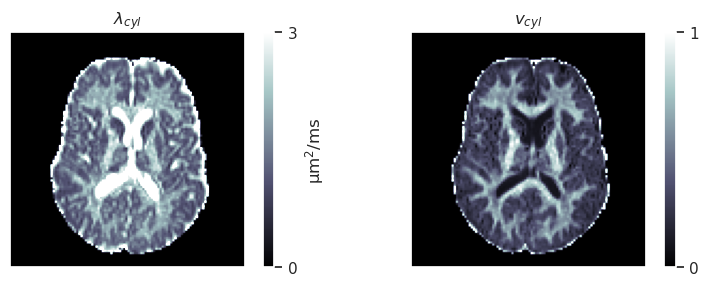

In [8]:
# Apply trained model on imaging data to see the results

data_img = nib.load("2-shell_HARDI_preprocessed/dwi.nii.gz")
data = data_img.get_fdata()
affine = data_img.affine
mask = nib.load("2-shell_HARDI_preprocessed/brain_mask.nii.gz").get_fdata().astype(bool)
bvals = np.round(np.loadtxt("2-shell_HARDI_preprocessed/dwi.bval"), -2) * 1e-3

data /= np.mean(data[..., np.where(bvals == 0)[0]], axis=-1)[
    ..., np.newaxis
]  # normalize

data_pa = np.zeros(data.shape[0:3] + (3,))
for i, b in enumerate(np.unique(bvals)):
    data_pa[..., i] = np.mean(data[..., np.where(bvals == b)[0]], axis=-1)

with torch.no_grad():
    preds = model(torch.tensor(data_pa[mask, 1::]).float().to(device))
    params = np.zeros(mask.shape + (2,))
    params[mask] = preds.detach().cpu()

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(np.rot90(params[..., 30, 0]), vmin=0, vmax=3, cmap="bone")
cbar = plt.colorbar(im)
cbar.set_ticks([0, 3])
cbar.set_label(r"μm$^2$/ms")
im = ax[1].imshow(np.rot90(params[..., 30, 1]), vmin=0, vmax=1, cmap="bone")
cbar = plt.colorbar(im)
cbar.set_ticks([0, 1])
ax[0].set_title(r"$\lambda_{cyl}$")
ax[1].set_title(r"$v_{cyl}$")
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].grid(False)
fig.tight_layout()
plt.show()

nib.save(nib.Nifti1Image(params, affine), "params_uniform.nii.gz")